In [1]:
# Import modules
import numpy as np
import time, os, sys, random
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
from cellpose import models
from cellpose.io import imread
from cellpose import plot
from skimage.util import img_as_ubyte
import pandas as pd

#------------------------------------------------------
test_round = 2

# Get path to folders containing images
#Image_Directory = os.getcwd() + "\\20151218_E14_BM_mTF8additionals_4"
Image_Directory = "C:/Users/Claudia/Desktop/Master EPFL/machine learning/project_2" + "/test"  #Easier for me (Alexis) than finding of to get my path file nicely
# other folders: 
# \\20151218_E14_BM_mTF8additionals_4
# "//20151125_BM_mTF8additionals_3//Composite_mBM-mTF8"
print(Image_Directory)


# Create Lists containing datapath to all images of Cherry/ Ypet files
image_format = "tif"
cherry_condition = "TexasRed"
ypet_condition = "YFP"
Cherry_file = []
Ypet_file = []

# Walk through directory (call all files) and assign them to proper list
for root, dirs, files in os.walk(Image_Directory, topdown=False): # root = given in Input, dirs = folders, files= files
    for f in files:
        if f.endswith(image_format) and cherry_condition in f: 
            Cherry_file.append(os.path.join(root, f))
        elif f.endswith(image_format) and ypet_condition in f: 
            Ypet_file.append(os.path.join(root, f))

assert len(Cherry_file) == len(Ypet_file), f"There are {len(Cherry_file)} Cherry files and {len(Ypet_file)} Ypet files. The number has to be equal, check manually what's missing"

# Initialize lists containing cherry, ypet images
cherry_imgs = np.ndarray(test_round,dtype = np.ndarray)
ypet_imgs = np.ndarray(test_round,dtype = np.ndarray)

# Read image (We donnot add it in for loop above to enable reading subset of image)
for i in range(test_round): #len(Cherry_file):
    cherry_imgs[i] = imread(Cherry_file[i])
    ypet_imgs[i] = imread(Ypet_file[i])
    
cherry_imgs = cherry_imgs.tolist()
ypet_imgs = ypet_imgs.tolist()


C:/Users/Claudia/Desktop/Master EPFL/machine learning/project_2/test


In [2]:
# Definine parameters for cellpose module using nuclei modus
# https://cellpose.readthedocs.io/en/latest/settings.html
channels = [0,0] # Corresponds to greyscale image
diameter = None # Model was trained on diameters of 17 pixels. None-> automated estimation of the diameter. Can be changed by hand later
flow_threshold = 0.4 # maximum allowed error of the flows for each mask, default = 0.4
gpu = False
model_type='nuclei'

# Set model
model = models.Cellpose(gpu, model_type)

# Nuclei segmentation of all images within cherry_imgs list
masks, flows, styles, diams = model.eval(cherry_imgs, diameter=diameter, channels=channels, flow_threshold=flow_threshold, do_3D=False)

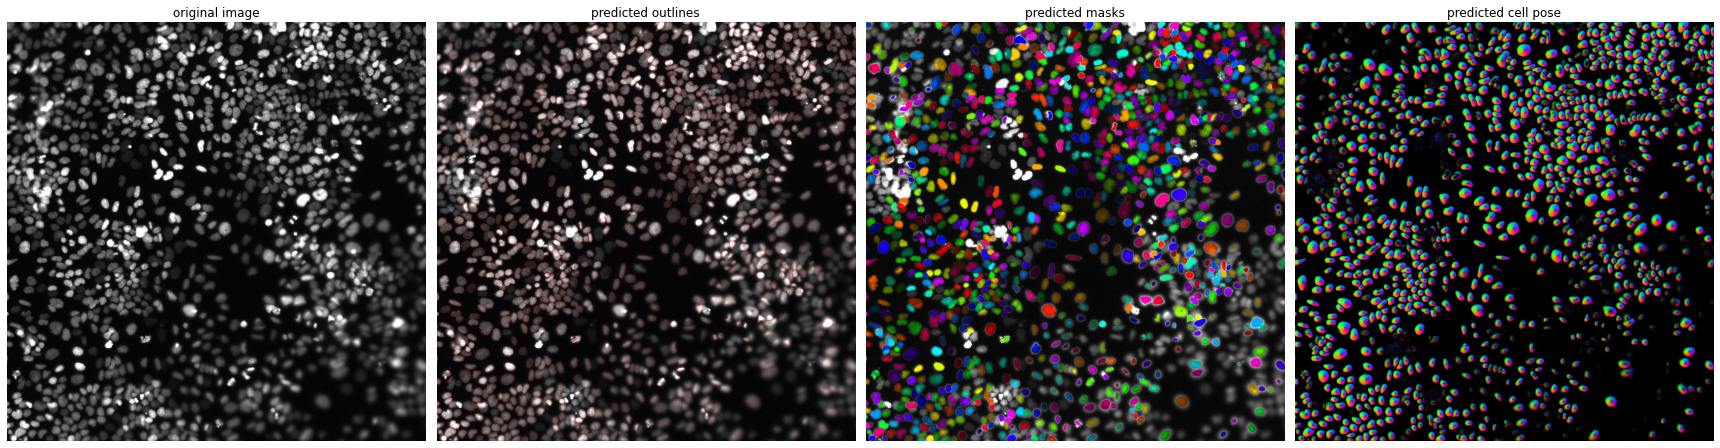

In [3]:
# Display results
image_i = 0
fig = plt.figure(figsize=(24,8))
plot.show_segmentation(fig, cherry_imgs[image_i], masks[image_i], flows[image_i][0], channels)
plt.tight_layout()
plt.show()

In [4]:
# For future usage, save matrix
'''
mat.dump("my_matrix.dat")
mat2 = numpy.load("my_matrix.dat")'''

'\nmat.dump("my_matrix.dat")\nmat2 = numpy.load("my_matrix.dat")'

In [5]:
# Try with first image: masks[0]
masks_df =  pd.DataFrame(masks[1])   #Putting 1 here (when test_round = 2 completely changes the results)
ypet_df = pd.DataFrame(ypet_imgs[1])
range_s = np.arange(1,959)  #IMAGE SPECIFIC: cases where cell are big enough (sell last cell of the notebook)
columnname = ["" for i in range_s]
patch_size = [0 for i in range_s]
mean_intensity = [0 for i in range_s]
sum_intensity = [0 for i in range_s]
median_intensity = [0 for i in range_s]
variance_intensity = [0 for i in range_s]

assert masks_df.shape == ypet_df.shape, f"Shape of mask is {masks_df.shape} and the shape of ypet image is { ypet_df.shape}. The size has to be the same. Check if normalization is needed"

# Calculate patch size and corresponding ypet signal (mean) and store it into ypet_intensity
for i in range_s : # masks_df.nunique().size 
    columnname[i-1] = "patch_" + str(i)                     #We should not forgot that there is a -1 here.
    patch_size[i-1] = (masks_df == i).values.sum()
    mean_intensity[i-1] = np.nanmean(ypet_df[masks_df==i])
    #sum_intensity[i-1] = np.sum(ypet_df[masks_df==i])
    #median_intensity[i-1] = np.nanmedian(ypet_df[masks_df==i])
    #variance_intensity[i-1] = np.var(ypet_df[masks_df==i])

In [6]:
print(ypet_df.shape)

(2048, 2048)


In [7]:
ypet_intensity = pd.DataFrame(index=columnname)
ypet_intensity['patch_size'] = patch_size
ypet_intensity['mean_intensity'] = mean_intensity

In [8]:
# Find relationship between nuclear size and expression level
# Apply ordinary least squares linear regression (For observational studies cross validation is not needed)
import statsmodels.formula.api as smf
mod = smf.ols(formula='patch_size ~ mean_intensity', data= ypet_intensity[1:960])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             patch_size   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.229
Date:                Wed, 07 Dec 2022   Prob (F-statistic):             0.0726
Time:                        11:17:07   Log-Likelihood:                -7195.5
No. Observations:                 957   AIC:                         1.439e+04
Df Residuals:                     955   BIC:                         1.440e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1043.7129     32.217     32.

In [9]:
print(ypet_intensity[ypet_intensity['patch_size']!=0])  #To see until which should go range_s

           patch_size  mean_intensity
patch_1           578     1714.724913
patch_2           340     2523.997059
patch_3           867     1689.582468
patch_4           720     1834.443056
patch_5           162     1426.030864
...               ...             ...
patch_954        1311     1653.927536
patch_955        1146     2851.648342
patch_956         912     3187.268640
patch_957         647     5002.820711
patch_958         743     2887.273217

[958 rows x 2 columns]


In [10]:
ypet_intensity['patch_size'] = patch_size
ypet_intensity['mean_intensity'] = mean_intensity
#ypet_intensity['sum_intensity'] = sum_intensity
#ypet_intensity['median_intensity'] = median_intensity
#ypet_intensity['variance_intensity'] = variance_intensity


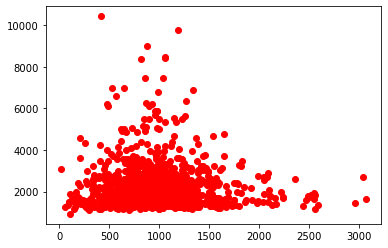

In [11]:
#plot for better visualization
plt.plot(patch_size, mean_intensity, 'ro')
#plt.yscale("log")
#plt.xscale("log")
plt.show()

In [221]:
#cross validation with polynomial expansion
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

In [222]:
X = patch_size.copy()
y = mean_intensity.copy()

In [223]:
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8)

In [224]:
x_train = np.array(x_train).reshape(-1, 1)
x_test = np.array(x_test).reshape(-1, 1)
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)


In [225]:
#model to select
maxdegree = 5 #To define is the maximum degree of the polynomial
training_error = []
cross_validation_ridge_error = []
cross_validation_lm_error = []

#see which degree fits data the best for linear regression
for d in range(1, maxdegree):
    #polynomial feature expansion of x_train
    x_poly_train = PolynomialFeatures(degree=d).fit_transform(x_train)
    #apply linear regression model
    lr = LinearRegression(fit_intercept=False)
    rr = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]) #values for alpha can be adapted
    #apply cross validation
    cve = cross_validate(lr,x_poly_train,y_train,scoring='neg_mean_squared_error', cv=5, return_train_score=True)
    crr = cross_validate(rr,x_poly_train,y_train,scoring='neg_mean_squared_error', cv=5, return_train_score=True)
    #make array for cross validation with linear model and for ridge regression
    cross_validation_lm_error.append(np.mean(np.absolute(cve['test_score']))) 
    cross_validation_ridge_error.append(np.mean(np.absolute(crr['test_score']))) 


In [ ]:
#find model with smallest mean squared error
if min(cross_validation_lm_error) <= min(cross_validation_ridge_error):
    print('uses a linear model')
    index_min_lm = np.argmin(cross_validation_lm_error)
    x_poly_test = PolynomialFeatures(degree=index_min+1).fit_transform(x_test)
    x_poly_train = PolynomialFeatures(degree=index_min+1).fit_transform(x_train)
    #make linear model
    model = smf.ols(formula='y_train ~ x_poly_train', data= ypet_intensity[1:len(x_poly_train)+1])
    result = model.fit()
    print(result.summary())
    #train error
    y_train_pred = result.predict(x_poly_train)
    mse_train = mean_squared_error(y_train,y_train_pred)
    #test error
    y_test_pred = result.predict(x_poly_test)
    mse_test = mean_squared_error(y_test,y_test_pred)


if min(cross_validation_lm_error) > min(cross_validation_ridge_error):
    print('uses a ridge regression model')
    index_min_rr = np.argmin(cross_validation_ridge_error)
    x_poly_test = PolynomialFeatures(degree=index_min_rr+1).fit_transform(x_test)
    x_poly_train = PolynomialFeatures(degree=index_min_rr+1).fit_transform(x_train)
    #make ridge model
    model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
    result = model.fit(x_poly_train, y_train)
    result.alpha_
    model = smf.ols(formula='y_train ~ x_poly_train', data= ypet_intensity[1:len(x_poly_train)+1])
    result = model.fit_regularized(alpha=result.alpha_, L1_wt=0.5, refit=True)
    print(result.summary())
    #train error
    y_train_pred = result.predict(x_poly_train)
    mse_train = mean_squared_error(y_train,y_train_pred)
    #test error
    y_test_pred = result.predict(x_poly_test)
    mse_test = mean_squared_error(y_test,y_test_pred)
    
    
plt.scatter(x_test, y_test, color="black")
plt.plot(x_test, y_test_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

uses a linear model
                            OLS Regression Results                            
Dep. Variable:                y_train   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     6.583
Date:                Wed, 07 Dec 2022   Prob (F-statistic):           0.000214
Time:                        12:54:45   Log-Likelihood:                -6401.2
No. Observations:                 766   AIC:                         1.281e+04
Df Residuals:                     762   BIC:                         1.283e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         710.

In [226]:
print('test error (MSE) :', mse_test)
print('train error (MSE) :', mse_train)

test error (MSE) : 1227940.2555167999
train error (MSE) : 1299537.3766387636
ERROR! Session/line number was not unique in database. History logging moved to new session 586


Text(0.5, 1.0, 'MSE for different degrees')

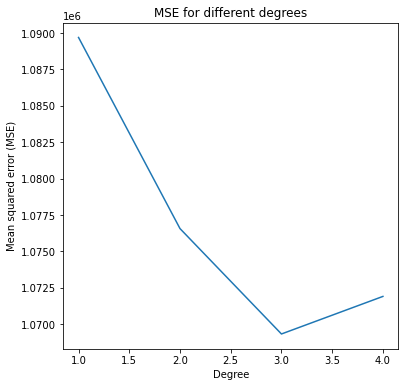

In [227]:
#Make plot to see which degree is the best for linear model
fig,ax=plt.subplots(figsize=(6,6))
ax.plot(range(1,maxdegree),cross_validation_lm_error)
ax.set_xlabel('Degree')
ax.set_ylabel('Mean squared error (MSE)')
ax.set_title('MSE for different degrees')

Text(0.5, 1.0, 'MSE for different degrees')

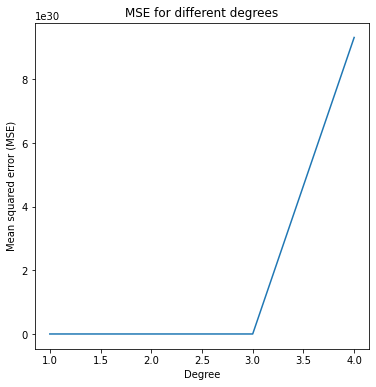

In [228]:
#Make plot to see which degree is the best for ridge regression
fig,ax=plt.subplots(figsize=(6,6))
ax.plot(range(1,maxdegree),cross_validation_ridge_error)
ax.set_xlabel('Degree')
ax.set_ylabel('Mean squared error (MSE)')
ax.set_title('MSE for different degrees')

C:\Users\Claudia\AppData\Local\Temp/ipykernel_42268/2679754759.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_test, y_test_pred, 'ro',color = 'black')


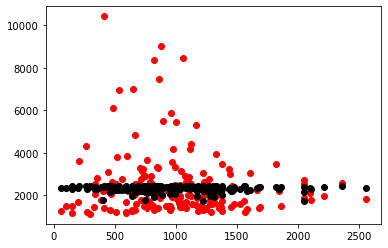

In [229]:
#show predicted things
plt.plot(x_test, y_test, 'ro')
plt.plot(x_test, y_test_pred, 'ro',color = 'black')
#plt.yscale("log")
#plt.xscale("log")
plt.show()

In [230]:
from statsmodels.graphics.regressionplots import abline_plot

In [231]:
result.params

Intercept          7.100976e+02
x_poly_train[0]    7.100970e+02
x_poly_train[1]    2.348980e+00
x_poly_train[2]   -1.745130e-03
x_poly_train[3]    3.383391e-07
dtype: float64

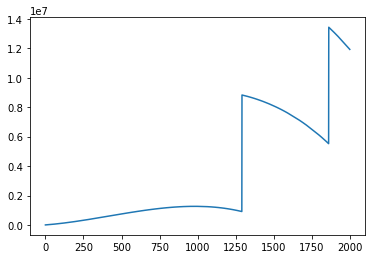

In [233]:
# Create the vectors X and Y
x = np.array(range(2000))
y = 797.0683 + 797.0685*x + 2.309019*x**2 + -0.001844546*x**3 +0.0000003718033*x**4

# Create the plot
plt.plot(x,y)

# Show the plot
plt.show()